In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [125]:
import logging
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [70]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )

In [71]:
replay_info

Continuous  Continuous_duration  \
animal day epoch ripple_number                                    
Cor    1   2     1                   False                0.000   
                 2                   False                0.000   
                 3                   False                0.000   
                 4                    True                0.078   
                 5                   False                0.000   
...                                    ...                  ...   
remy   37  4     297                  True                0.006   
                 298                 False                0.000   
                 299                 False                0.000   
                 300                 False                0.000   
                 301                 False                0.000   

                                Continuous_max_probability  \
animal day epoch ripple_number                               
Cor    1   2     1                                0.433000   
                 2                                0.145381   
                 3                                0.253176   
                 4                                0.984090   
                 5                                0.471484   
...                                                    ...   
remy   37  4     297                              0.802647   
                 298                              0.475871   
                 299                              0.294700   
                 300                              0.313890   
                 301                              0.332840   

                                Continuous_max_time  Continuous_min_time  \
animal day epoch ripple_number                                             
Cor    1   2     1                              NaN                  NaN   
                 2                              NaN                  NaN   
                 3                              NaN                  NaN   
                 4                             76.0                  0.0   
                 5                              NaN                  NaN   
...                                             ...                  ...   
remy   37  4     297                           60.0                 56.0   
                 298                            NaN                  NaN   
                 299                            NaN                  NaN   
                 300                            NaN                  NaN   
                 301                            NaN                  NaN   

                                Continuous_n_total_spikes  \
animal day epoch ripple_number                              
Cor    1   2     1                                    NaN   
                 2                                    NaN   
                 3                                    NaN   
                 4                                  115.0   
                 5                                    NaN   
...                                                   ...   
remy   37  4     297                                167.0   
                 298                                  NaN   
                 299                                  NaN   
                 300                                  NaN   
                 301                                  NaN   

                                Continuous_n_unique_spiking  \
animal day epoch ripple_number                                
Cor    1   2     1                                      NaN   
                 2                                      NaN   
                 3                                      NaN   
                 4                                      9.0   
                 5                                      NaN   
...                                                     ...   
remy   37  4     297                                   19.0   
   

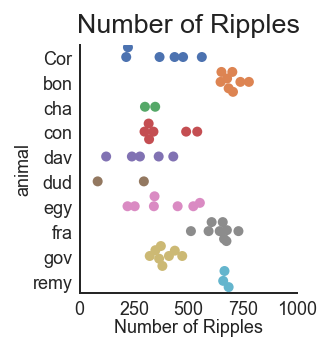

In [135]:
n_ripples_by_day = (
    replay_info.groupby(["animal", "day"])
    .is_classified.size()
    .rename("Number of Ripples")
)

sns.catplot(
    data=n_ripples_by_day.reset_index(),
    x="Number of Ripples",
    y="animal",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
)
plt.xlim((0, 1000))
plt.title("Number of Ripples")

save_figure("figure3_n_ripples")

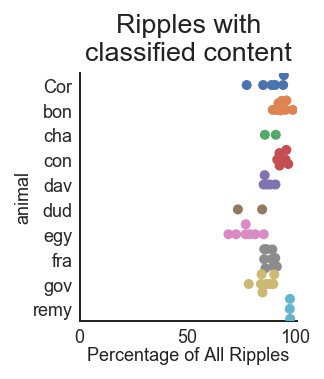

In [137]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of All Ripples",
    y="animal",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
)
plt.xlim((0, 101))
plt.title("Ripples with\nclassified content")

save_figure("figure3_ripples_with_classified_content")

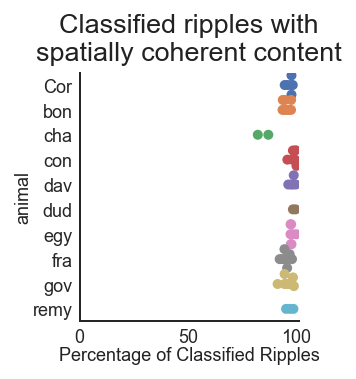

In [151]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)
for kind in ["swarm"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
        height=PAGE_HEIGHT / 4,
    )
    plt.xlim((0, 101))
    plt.title("Classified ripples with\nspatially coherent content")

save_figure("figure3_classified_ripples_with_some_spatially_coherent_content")

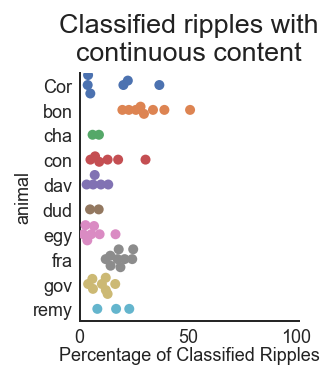

In [158]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="animal",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
)
plt.xlim((0, 101))
plt.title("Classified ripples with\ncontinuous content")
save_figure("figure3_classified_ripples_with_some_continuous_content")

Text(0.5, 1, 'Classified ripples with\nfragmented content')

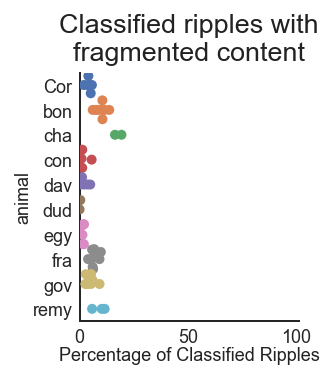

In [156]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["Fragmented"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="animal",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
)
plt.xlim((0, 101))
plt.title("Classified ripples with\nfragmented content")

In [ ]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(
        lambda df: (
            df["Hover"]
            & ~(
                df["Hover-Continuous-Mix"]
                | df["Continuous"]
                | df["Fragmented-Continuous-Mix"]
                | df["Fragmented"]
            )
        ).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)

sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="animal",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
)
plt.xlim((0, 101))
plt.title("Ripples with\nexclusively hover content")

Text(0.5, 1, 'Ripples with\nexclusively hover content')

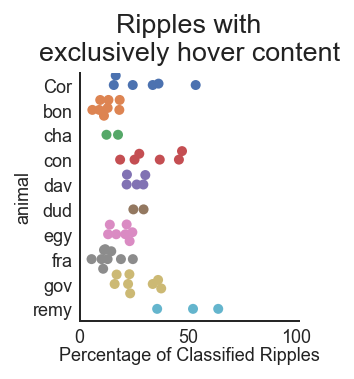

In [142]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["animal", "day"])
    .apply(
        lambda df: (
            df["Hover"]
            & ~(
                df["Hover-Continuous-Mix"]
                | df["Continuous"]
                | df["Fragmented-Continuous-Mix"]
                | df["Fragmented"]
            )
        ).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)

sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="animal",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
)
plt.xlim((0, 101))
plt.title("Ripples with\nexclusively hover content")

Text(0.5, 1, 'Ripples with\nsome Continuous content')

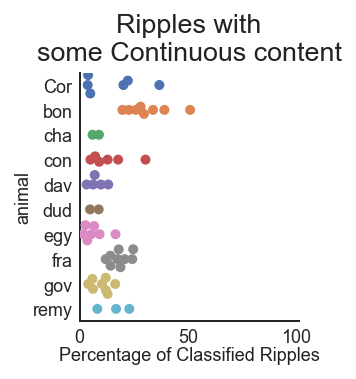

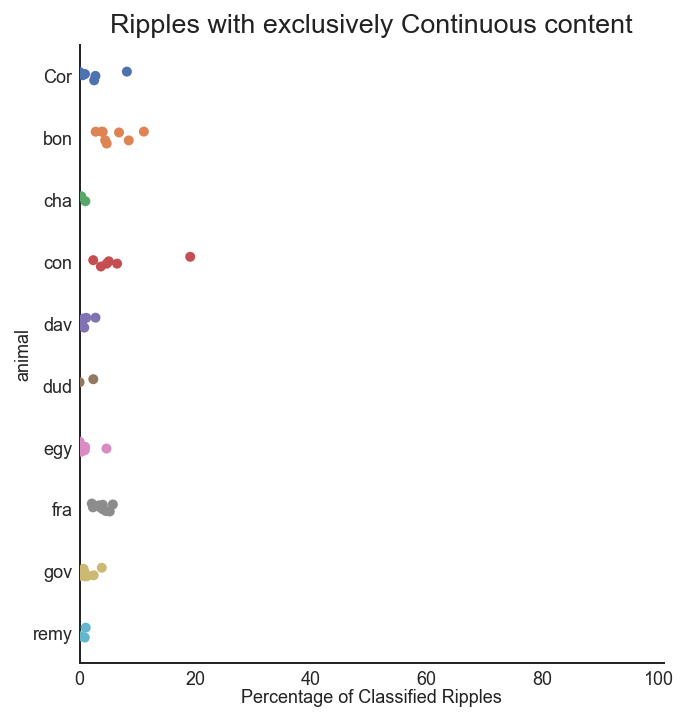

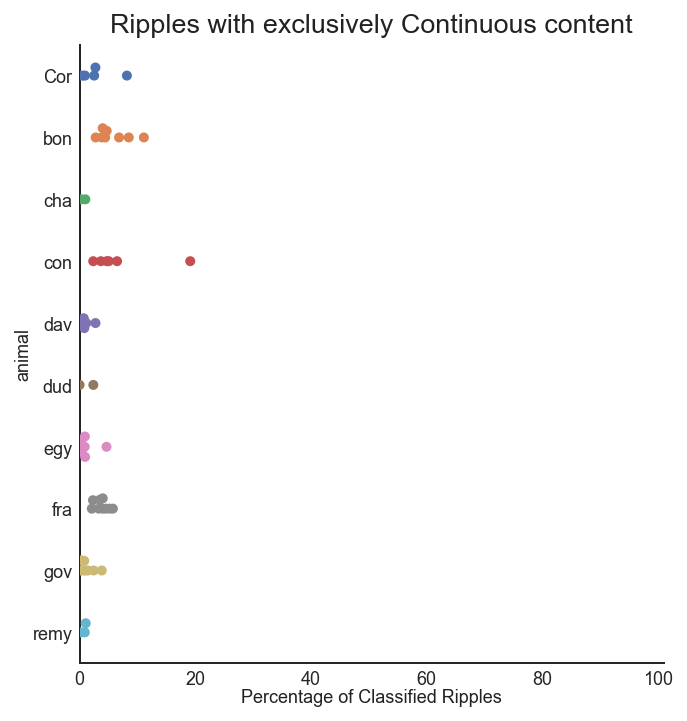

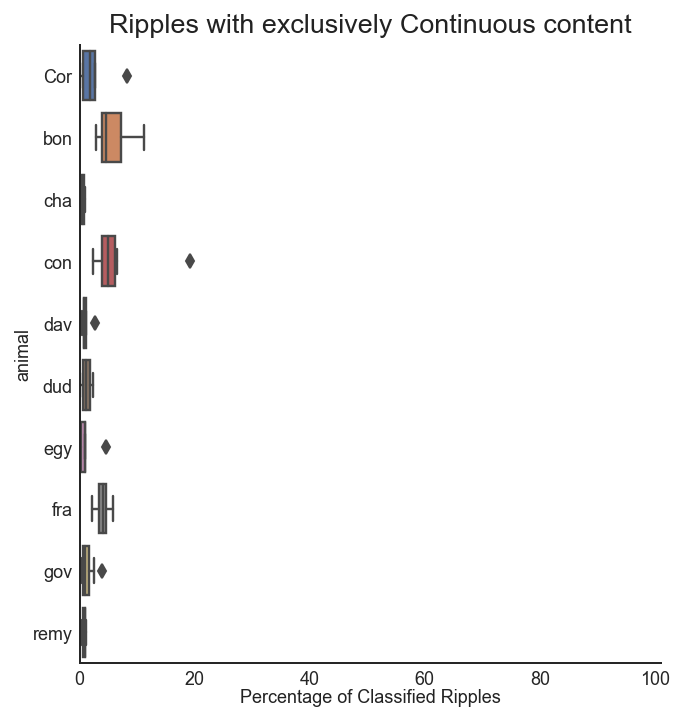

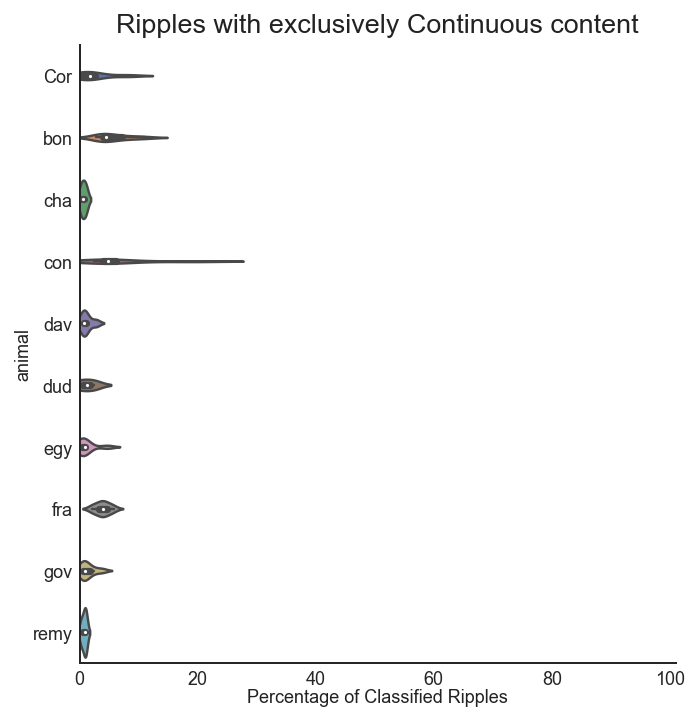

In [77]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(
        lambda df: (
            df["Continuous"]
            & ~(
                df["Hover"]
                | df["Hover-Continuous-Mix"]
                | df["Fragmented-Continuous-Mix"]
                | df["Fragmented"]
            )
        ).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with exclusively Continuous content")

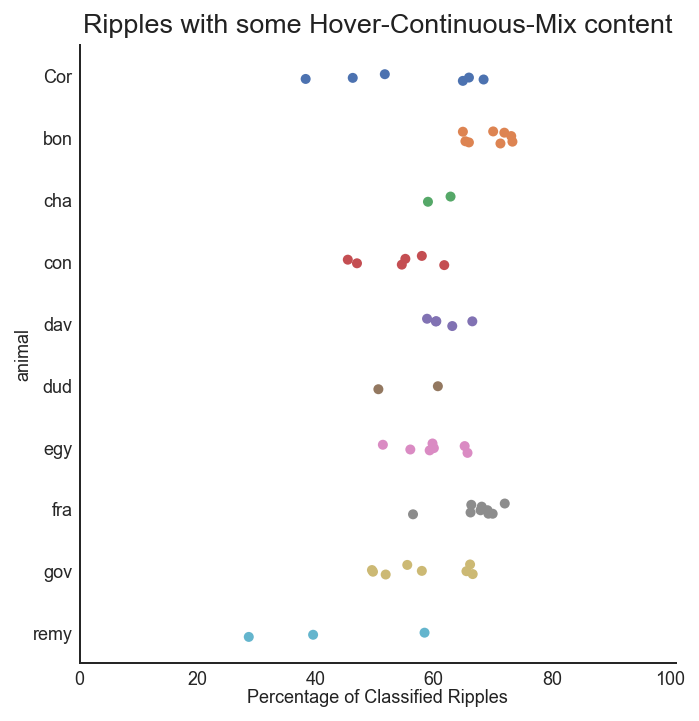

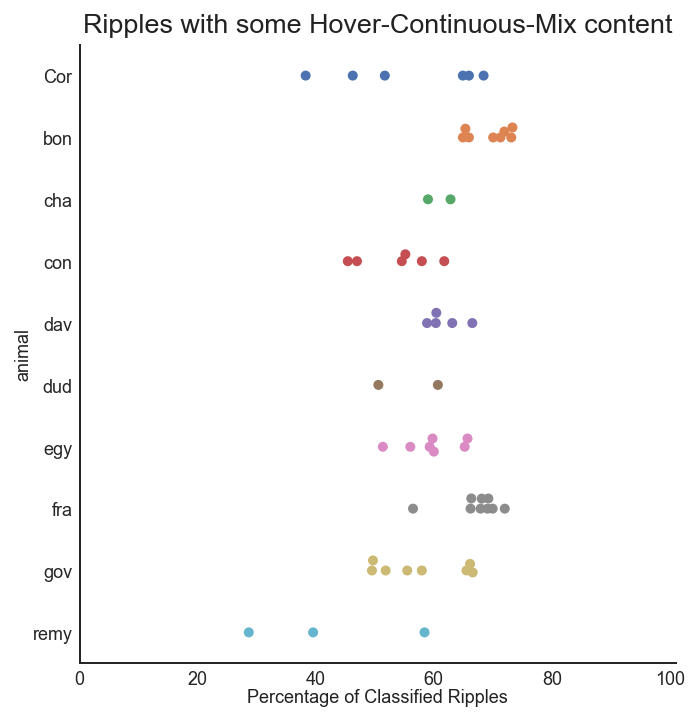

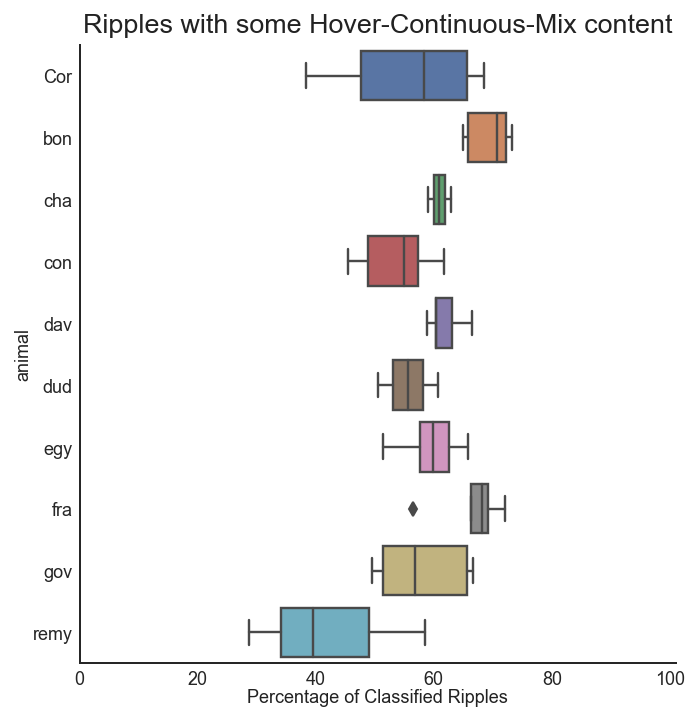

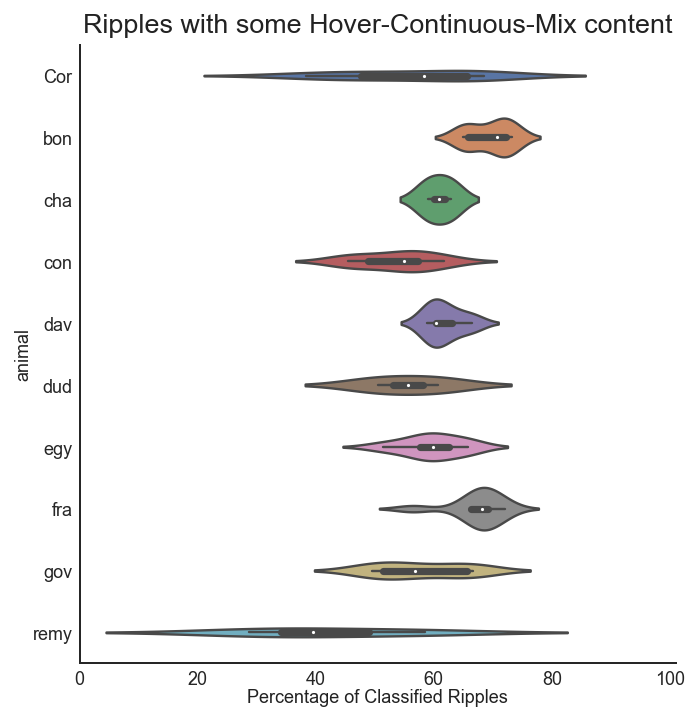

In [78]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["Hover-Continuous-Mix"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some Hover-Continuous-Mix content")

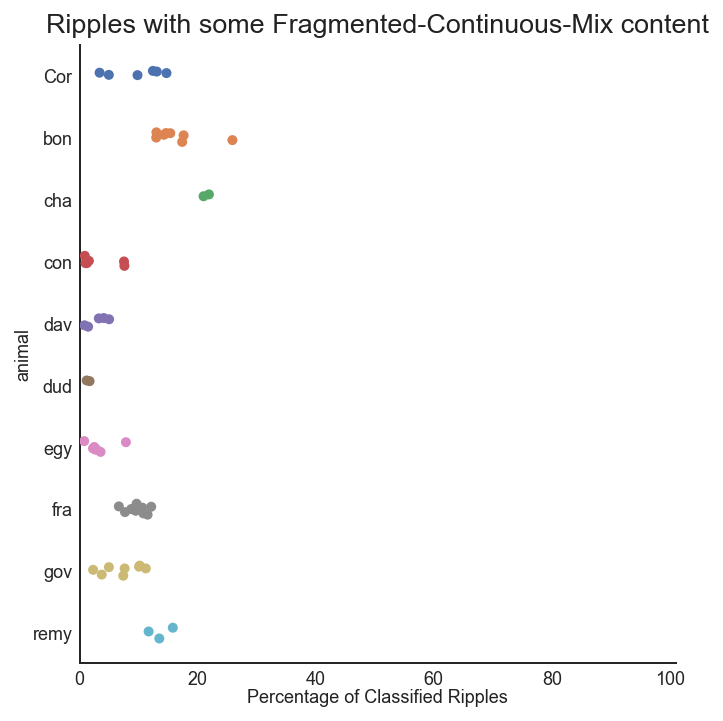

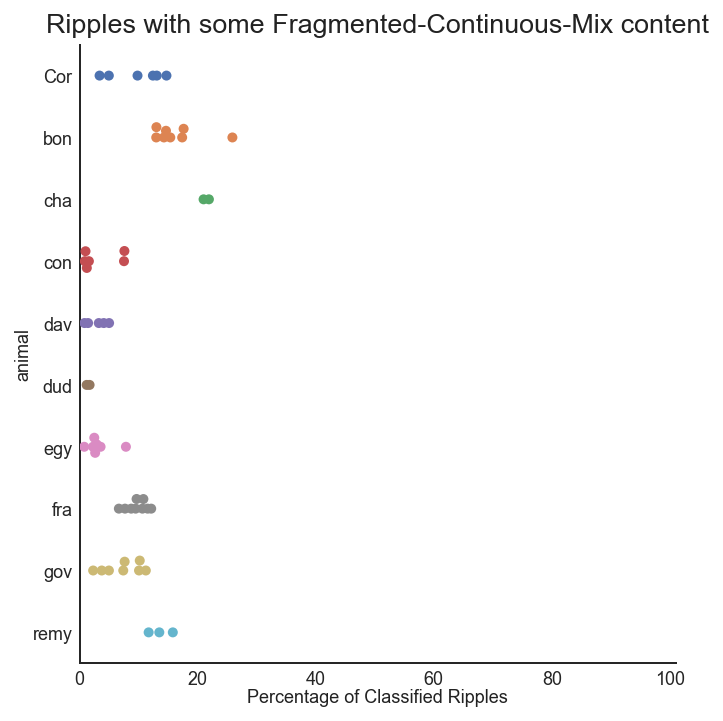

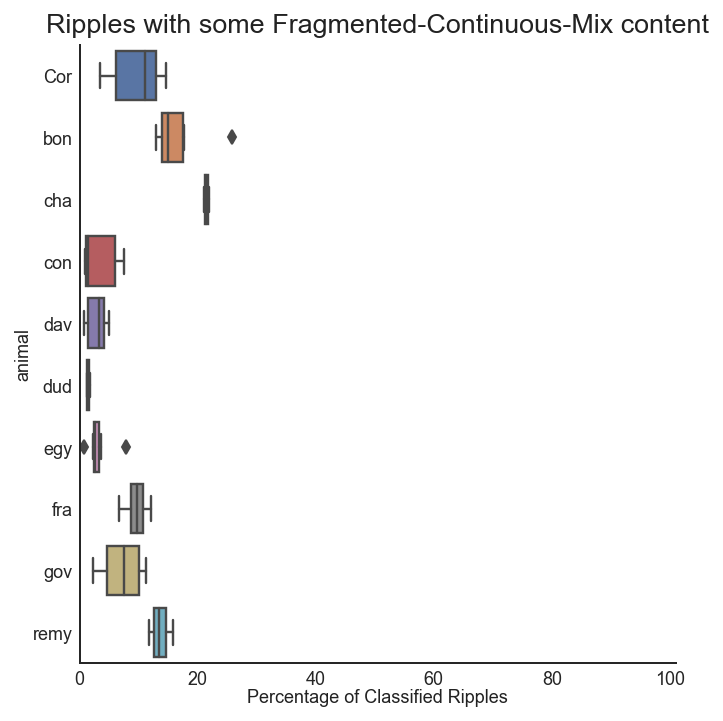

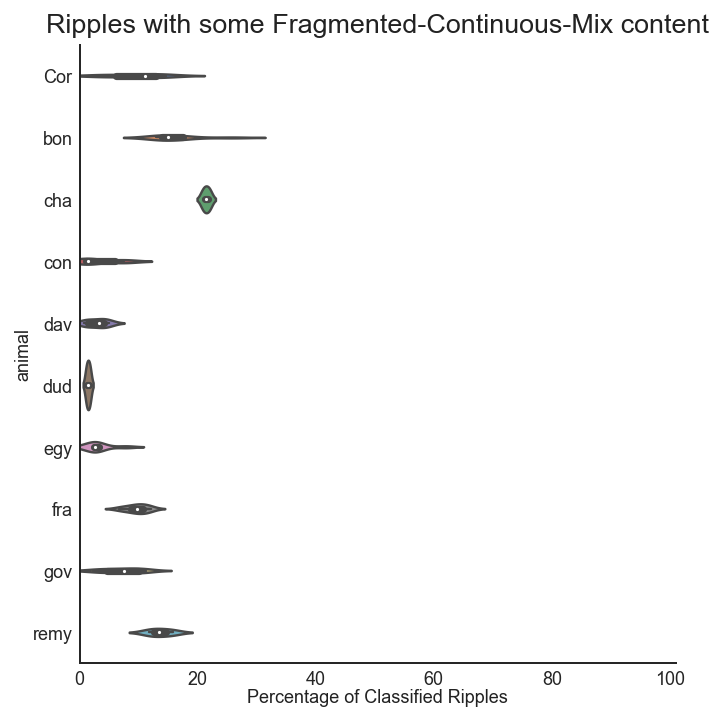

In [79]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["Fragmented-Continuous-Mix"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some Fragmented-Continuous-Mix content")

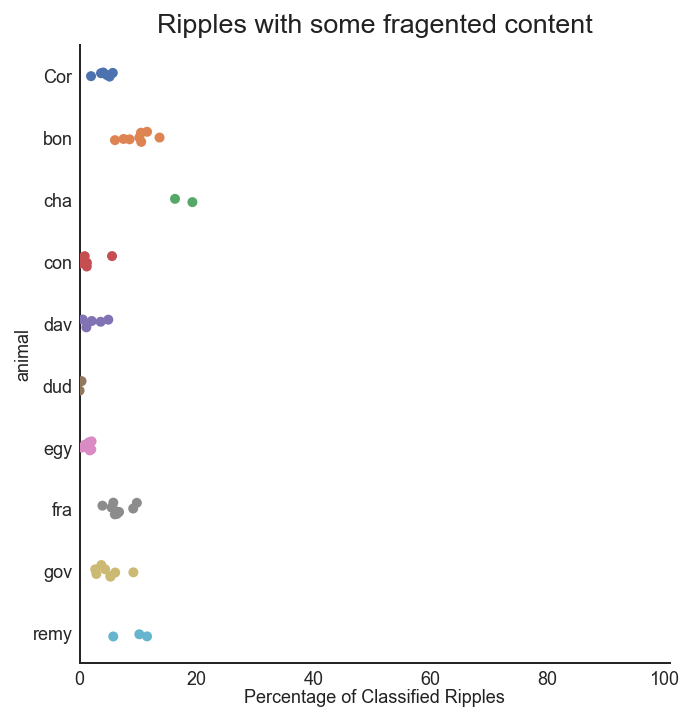

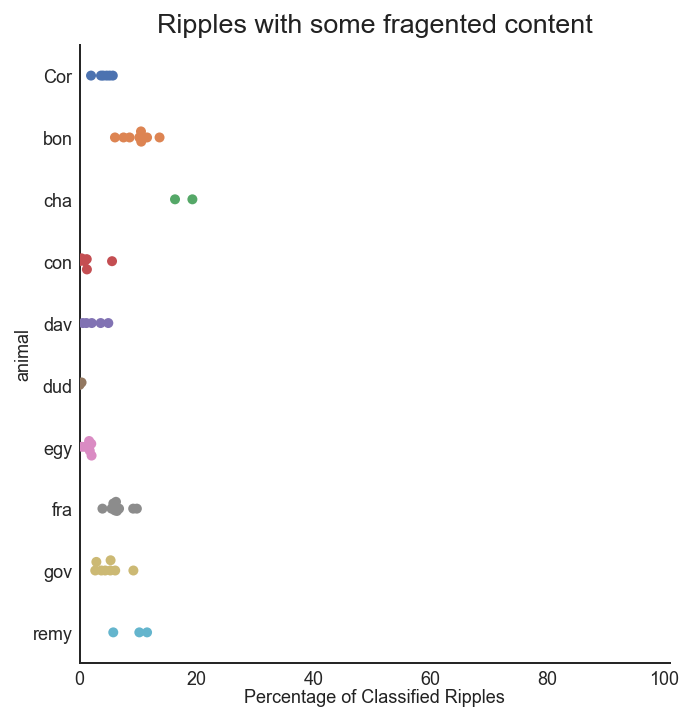

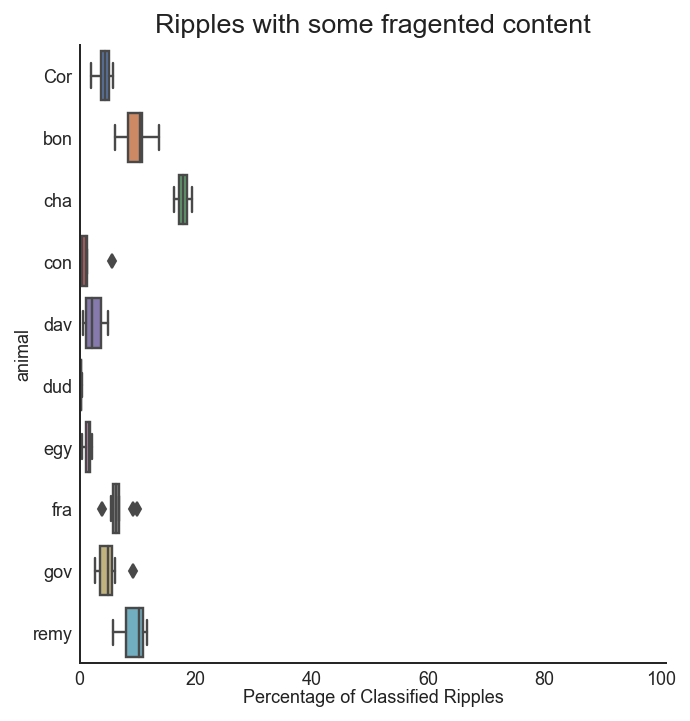

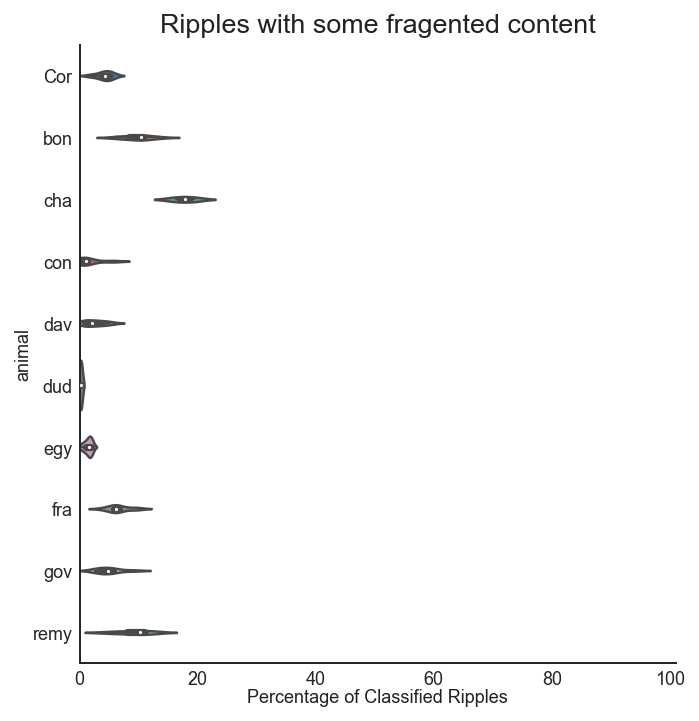

In [80]:
df = (
    replay_info.groupby(["animal", "day"])
    .apply(lambda df: (df["Fragmented"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)

for kind in ["strip", "swarm", "box", "violin"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="animal",
        ci="sd",
        kind=kind,
    )
    plt.xlim((0, 101))
    plt.title("Ripples with some fragented content")

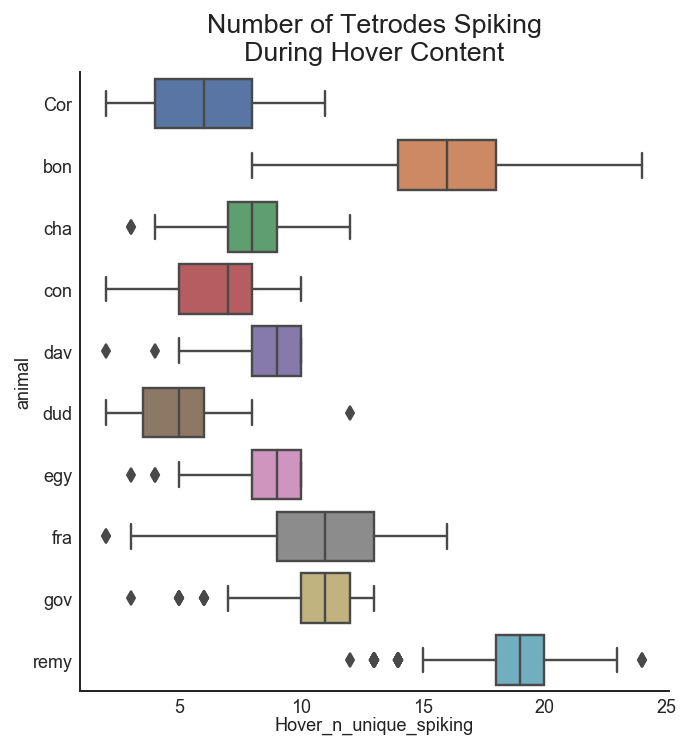

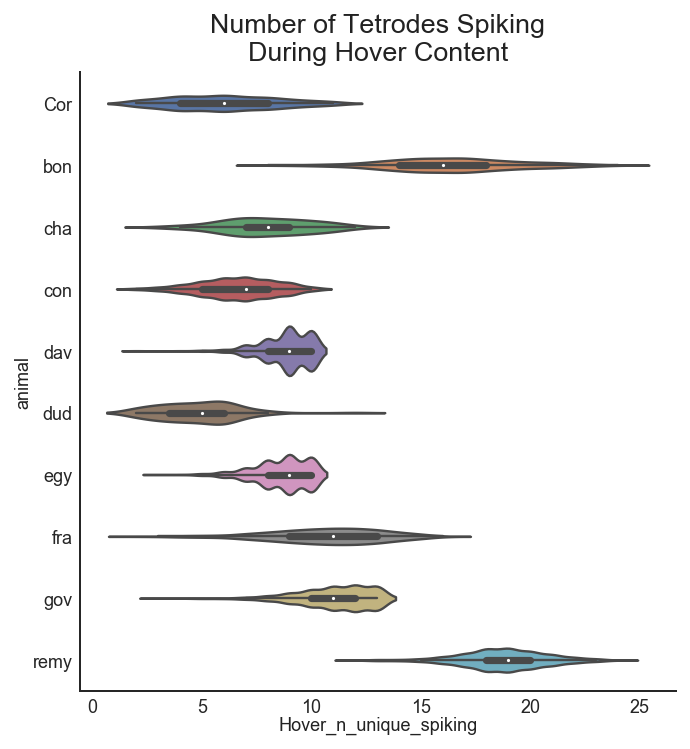

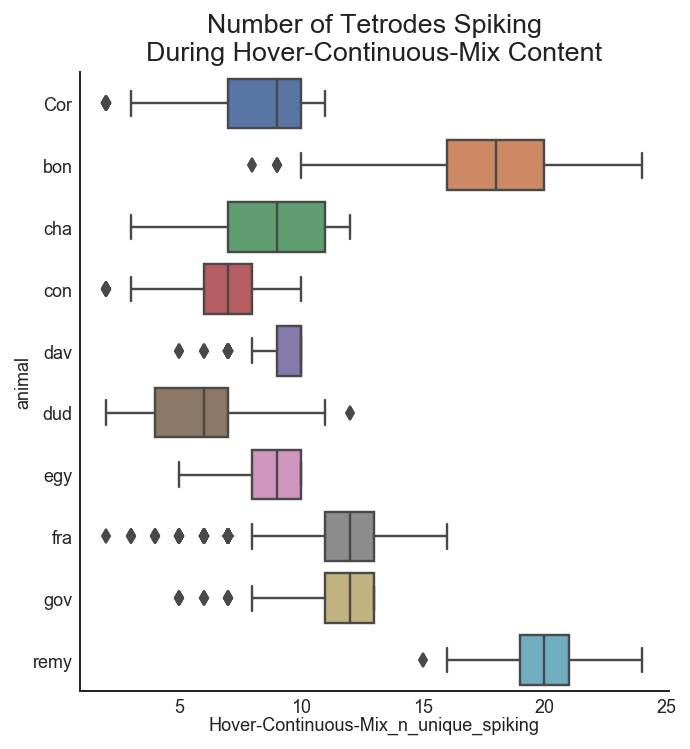

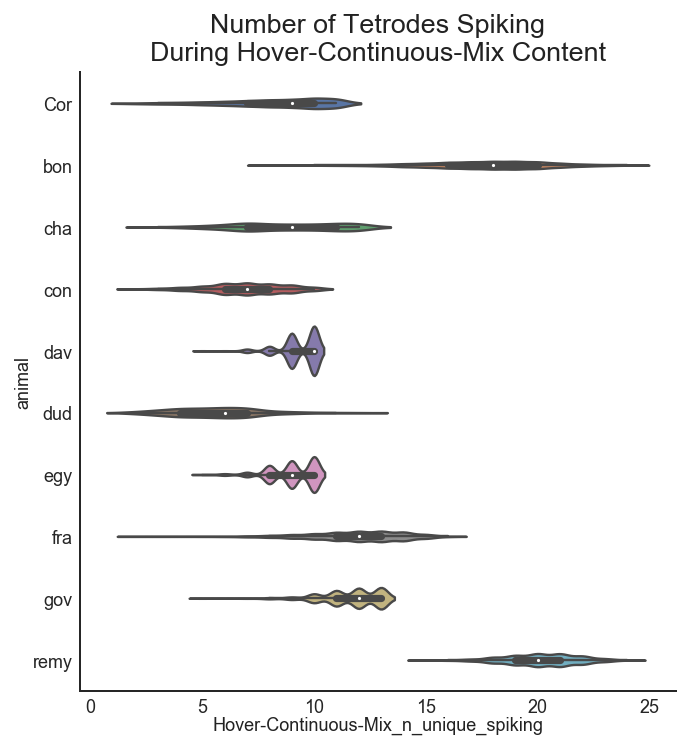

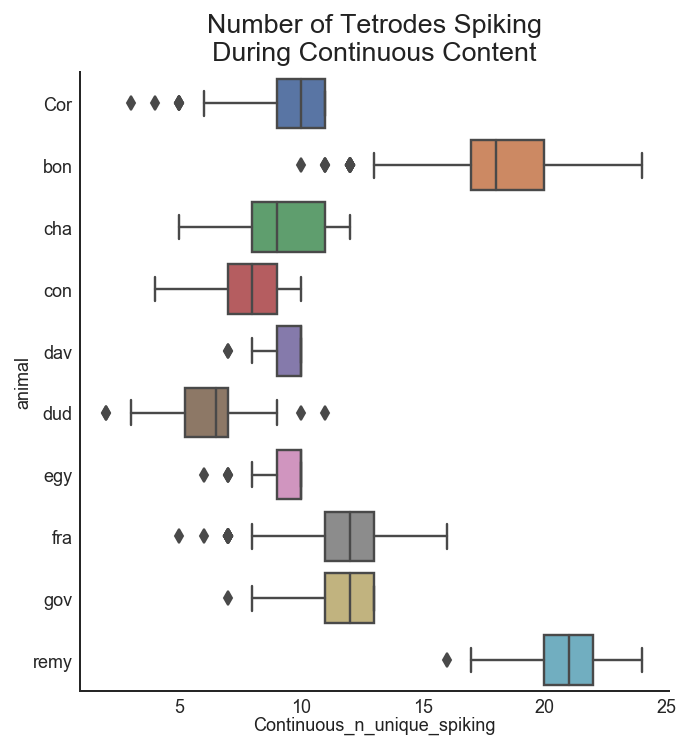

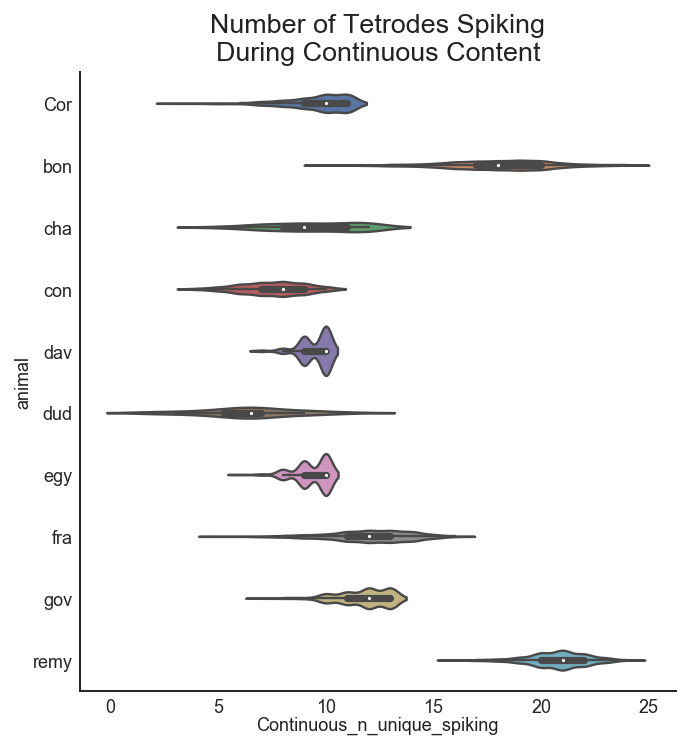

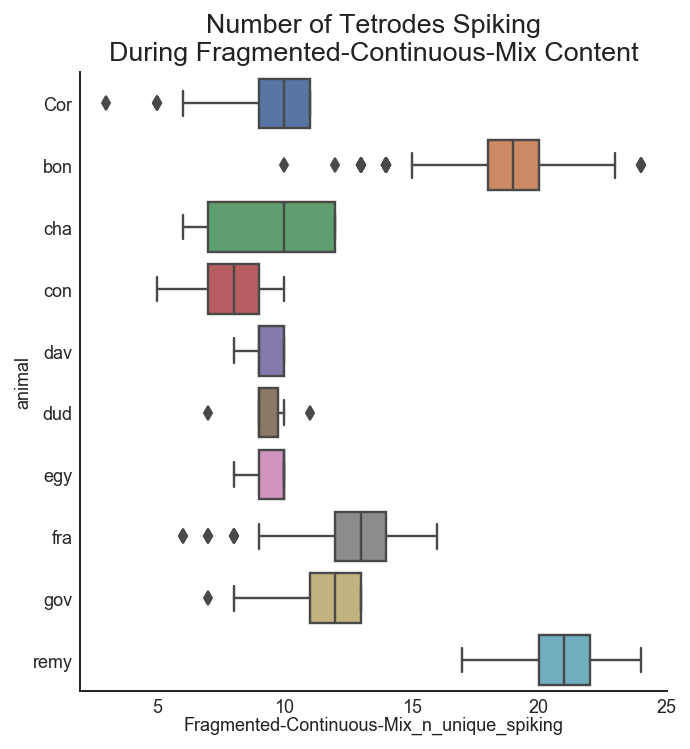

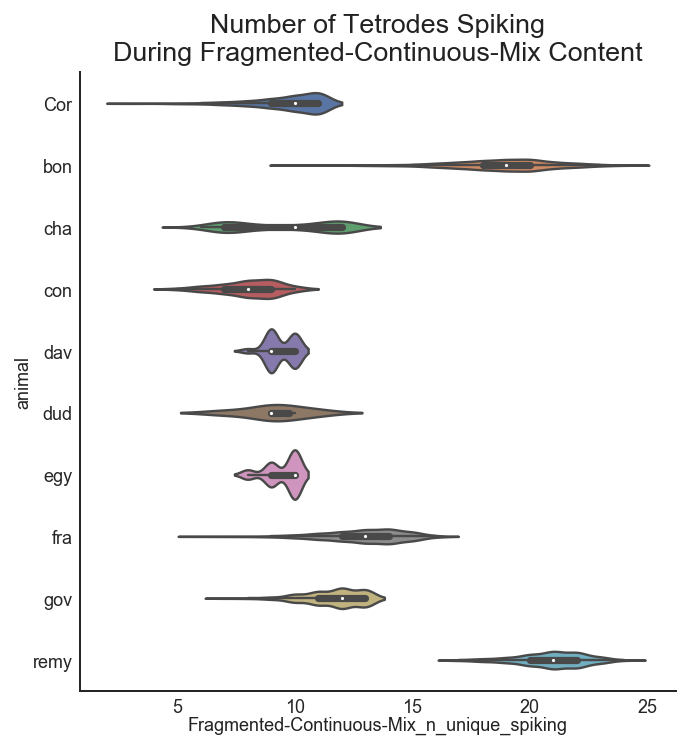

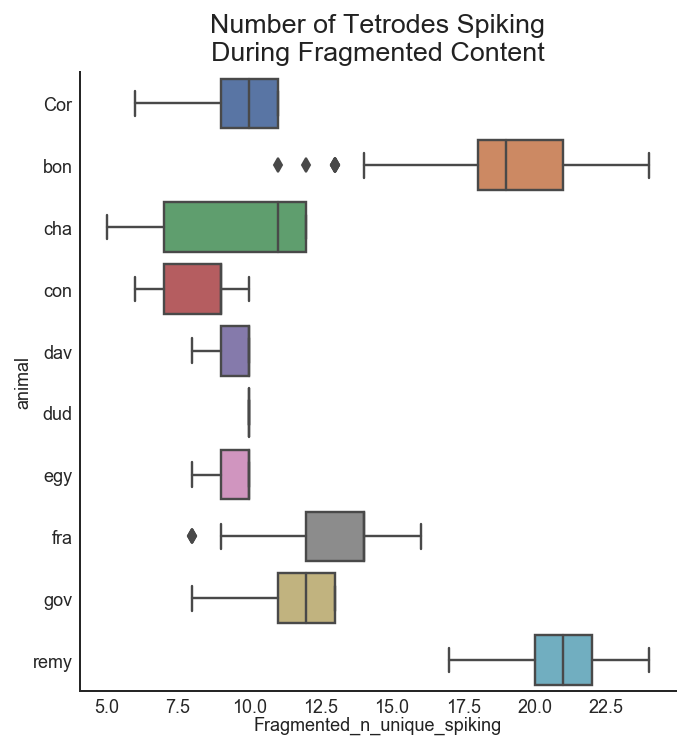

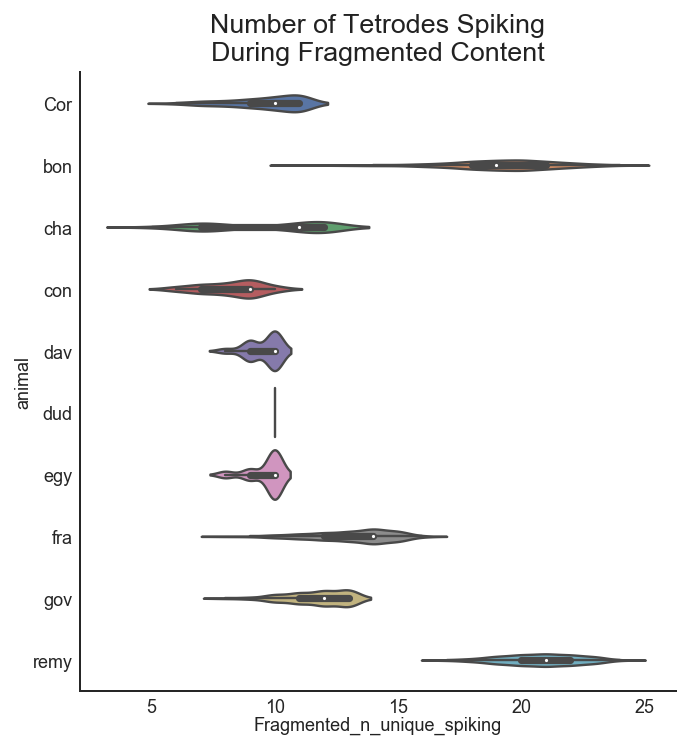

In [83]:
df = replay_info
for state in STATE_ORDER:
    for kind in ["box", "violin"]:
        sns.catplot(
            data=df.reset_index(),
            x=f"{state}_n_unique_spiking",
            y="animal",
            ci="sd",
            kind=kind,
        )
        plt.title(f"Number of Tetrodes Spiking\nDuring {state} Content")

Text(0.5, 14.415200000000011, 'Number of Tetrodes Participating')

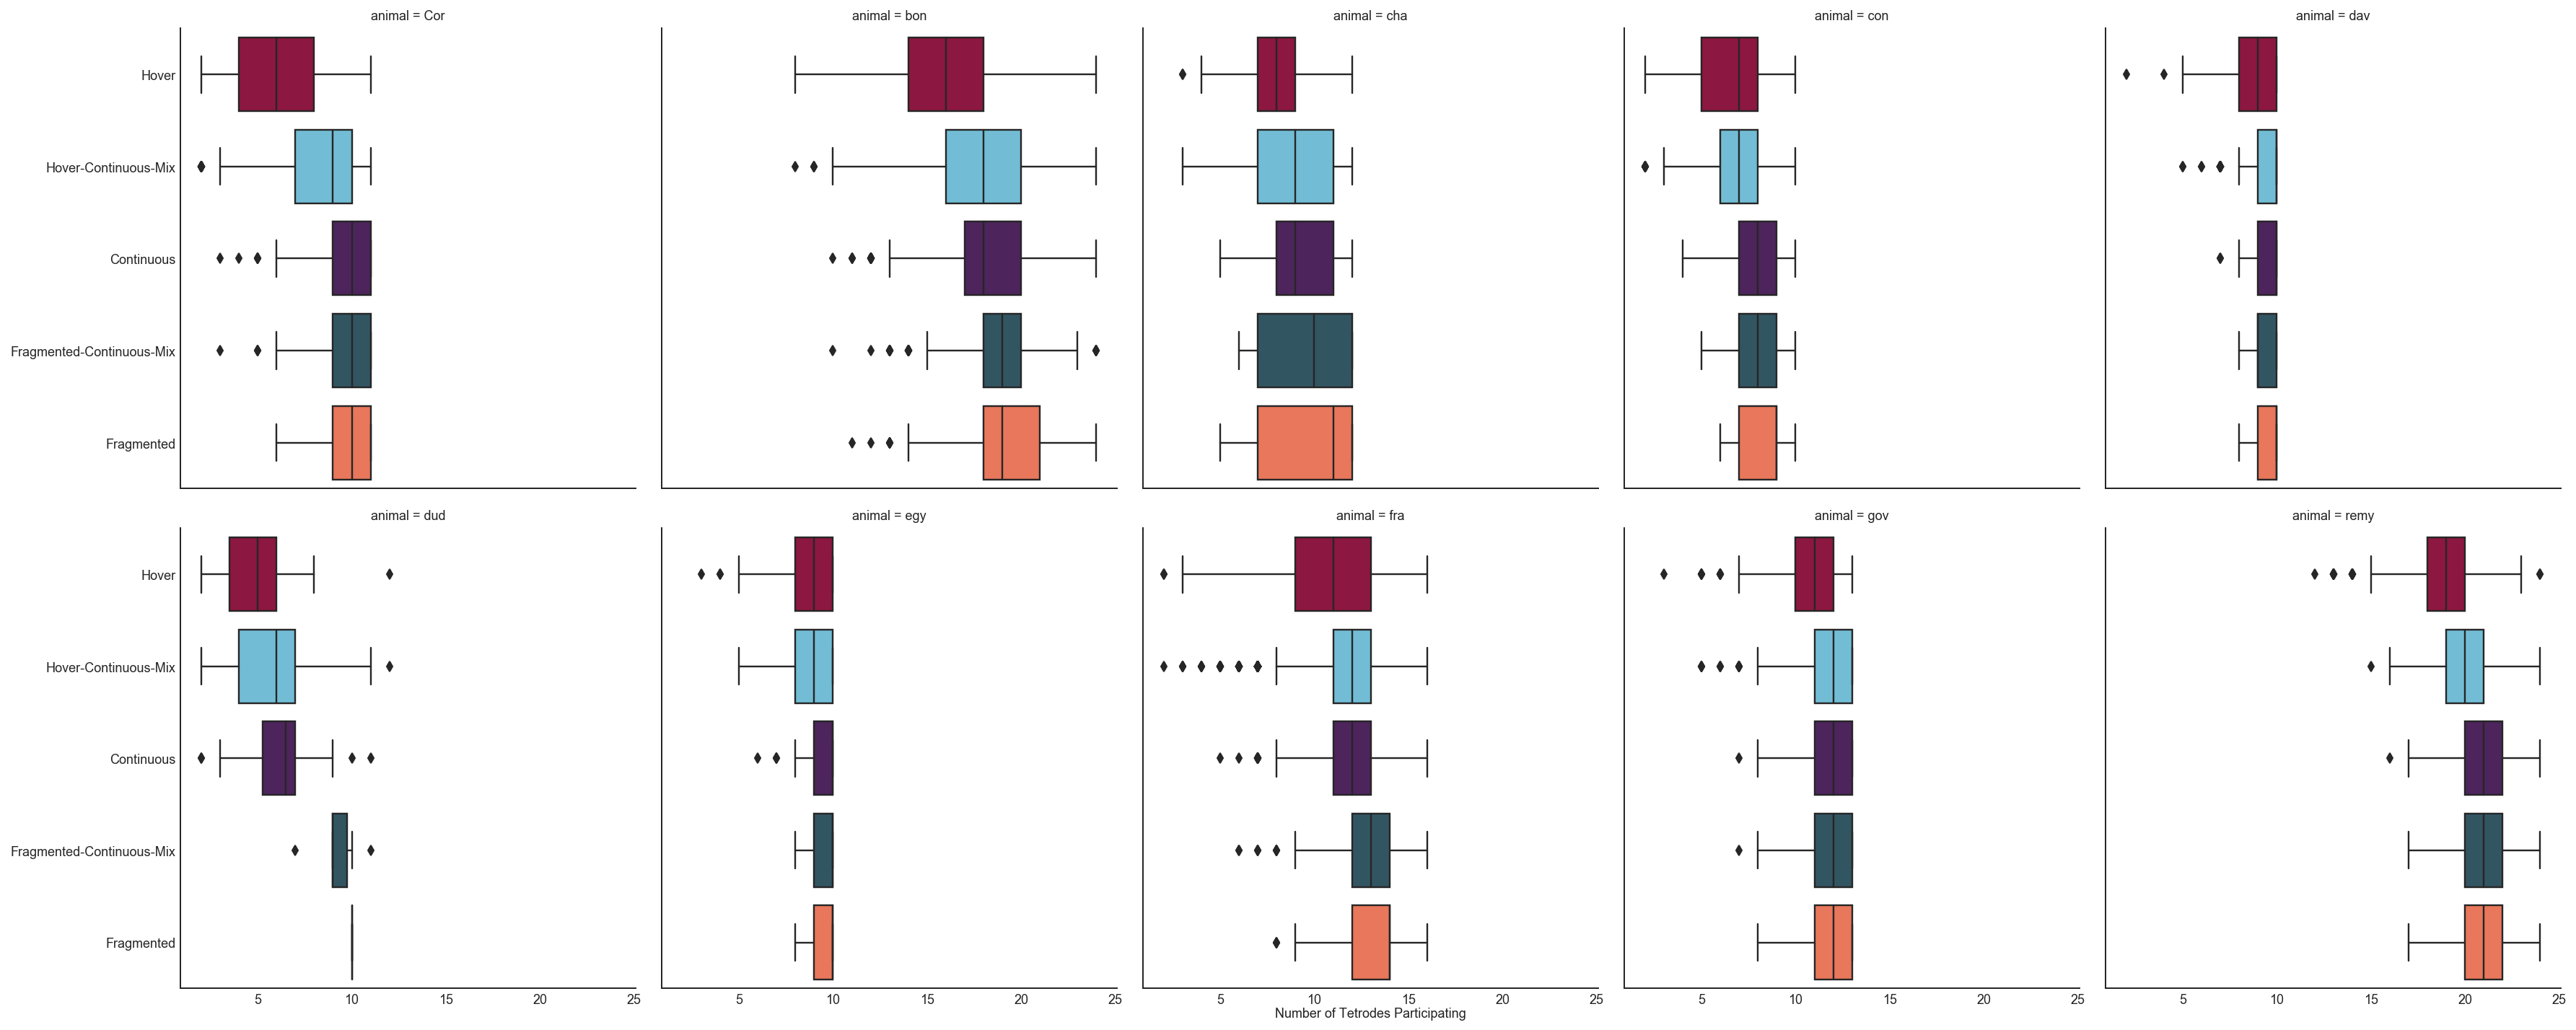

In [165]:
df = replay_info.filter(like="_n_unique_spiking", axis=1).rename(
    columns=lambda col: col.replace("_n_unique_spiking", "")
)
h = sns.catplot(
    data=df.reset_index().drop(columns=["day", "epoch", "ripple_number"]),
    col="animal",
    col_wrap=5,
    kind="box",
    order=STATE_ORDER,
    orient="horizontal",
    palette=STATE_COLORS,
)
h.axes[7].set_xlabel("Number of Tetrodes Participating")

(10.0, 1000000.0)

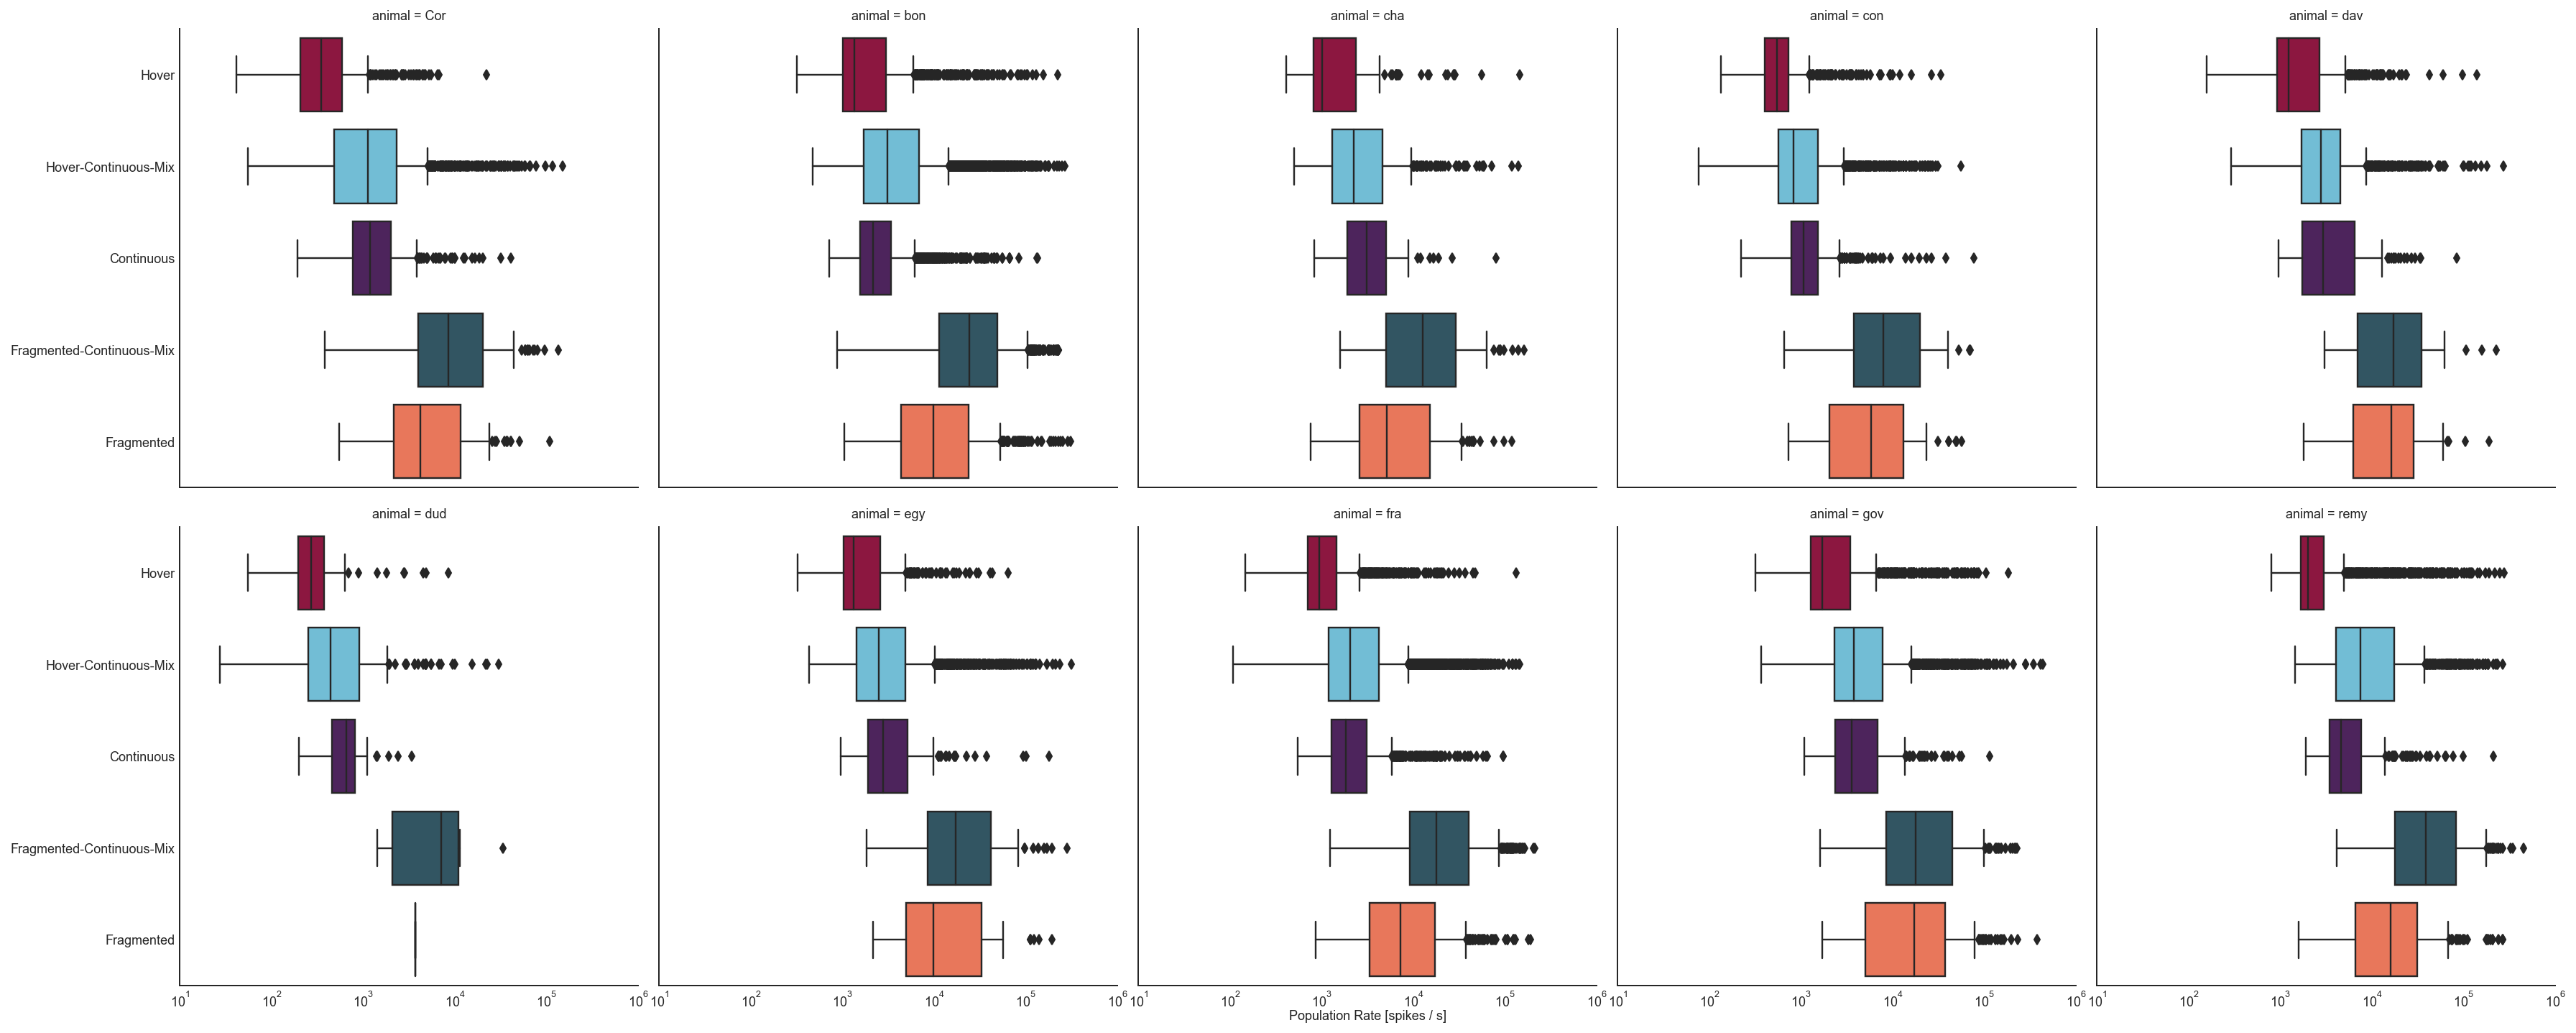

In [166]:
df = replay_info.filter(like="_population_rate", axis=1).rename(
    columns=lambda col: col.replace("_population_rate", "")
)
h = sns.catplot(
    data=df.reset_index().drop(columns=["day", "epoch", "ripple_number"]),
    col="animal",
    col_wrap=5,
    kind="box",
    order=STATE_ORDER,
    orient="horizontal",
    palette=STATE_COLORS,
)
h.axes[7].set_xlabel("Population Rate [spikes / s]")
plt.xscale("log")
plt.xlim((1e1, 1e6))

In [164]:
sns.catplot?

Signature:
sns.catplot(
    x=None,
    y=None,
    hue=None,
    data=None,
    row=None,
    col=None,
    col_wrap=None,
    estimator=<function mean at 0x10ce257b8>,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=None,
    hue_order=None,
    row_order=None,
    col_order=None,
    kind='strip',
    height=5,
    aspect=1,
    orient=None,
    color=None,
    palette=None,
    legend=True,
    legend_out=True,
    sharex=True,
    sharey=True,
    margin_titles=False,
    facet_kws=None,
    **kwargs,
)
Docstring:
Figure-level interface for drawing categorical plots onto a
:class:`FacetGrid`.

This function provides access to several axes-level functions that
show the relationship between a numerical and one or more categorical
variables using one of several visual representations. The ``kind``
parameter selects the underlying axes-level function to use:

Categorical scatterplots:

- :func:`stripplot` (with ``kind="strip"``; the default)
- :func:`swarmplot` (w